In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16328535294513283531
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6211091698425409218
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6750224605296515249
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10927236711
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16018838363055659627
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
m

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [3]:
cd /media/datastorage/Phong/cifar100_png/

/media/datastorage/Phong/cifar100_png


In [4]:
ls -l

total 3420144
drwxrwxr-x   2 bribeiro bribeiro       4096 ago 10 00:45 checkpoints/
-rw-rw-r--   1 bribeiro bribeiro     283919 ago  9 23:36 Cifar10_SeResNet101_MulModels299_STD_1511_v8.csv
drwxrwxr-x   2 bribeiro bribeiro       4096 ago  9 23:38 pred_npy/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 20:55 test/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 21:08 test_resized/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 23:03 test_resized_299/
-rw-rw-r--   1 bribeiro bribeiro  585393095 ago 10 02:22 test_resized_299.zip
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 20:55 train/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 21:06 train_resized/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 22:59 train_resized_299/
-rw-rw-r--   1 bribeiro bribeiro 2916502920 ago 10 02:24 train_resized_299.zip


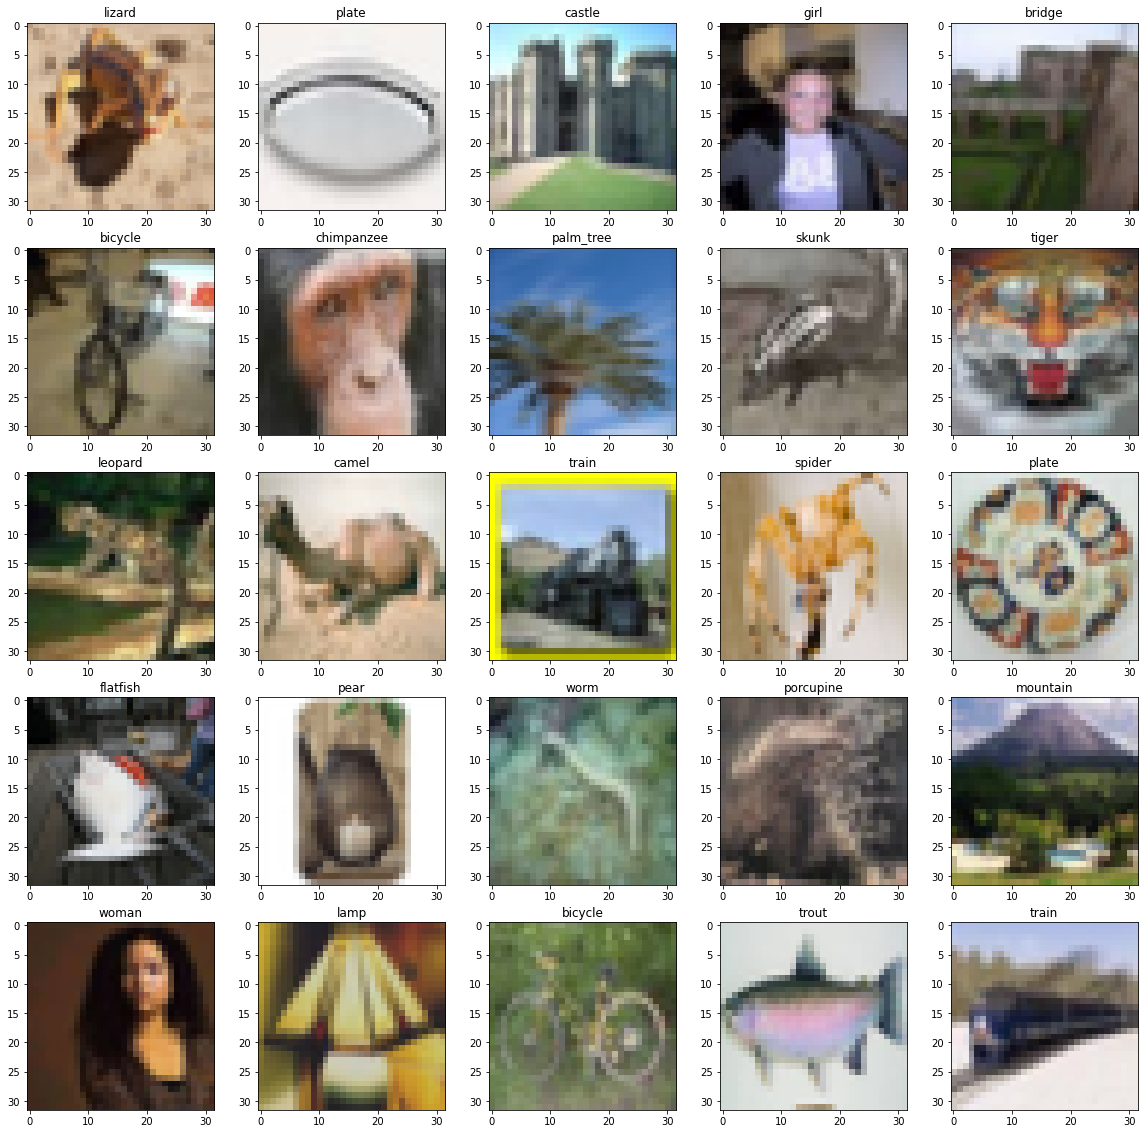

In [5]:
#Images/n02105855-Shetland_sheepdog/n02105855_9415.jpg

import glob
import os

import numpy as np
from matplotlib.image import imread
%matplotlib inline
import matplotlib.pyplot as plt

# get image parts
def get_image_parts(image_path):
    """Given a full path to an image, return its parts."""
    parts = image_path.split(os.path.sep)
    #print(parts)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]
    
    return train_or_test, classname, filename_no_ext, filename
    
    
sample_images = list(glob.glob(os.path.join('train/', '*/*'), recursive=True))
np.random.seed(42)
rand_imgs = np.random.choice(sample_images, size=5*5)
fig, axarr = plt.subplots(5, 5, figsize=(20, 20))

for i, rand_img in enumerate(rand_imgs):
    train_or_test, classname, filename_no_ext, filename = get_image_parts(rand_img)
    
    j = i // 5
    k = i % 5
    axarr[j][k].imshow(imread(rand_img))
    axarr[j][k].title.set_text(classname)
    axarr[j][k].grid(False)

In [4]:
## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)


Using TensorFlow backend.


In [5]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                    

    100% |████████████████████████████████| 1.5MB 5.0MB/s ta 0:00:01
  Found existing installation: pip 18.0
    Uninstalling pip-18.0:
      Successfully uninstalled pip-18.0
  Rolling back uninstall of pip
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python2.7/dist-packages/pip/__init__.py'
Consider using the `--user` option or check the permissions.

You are using pip version 18.0, however version 20.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
# !pip3 install -U git+https://github.com/qubvel/efficientnet

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-vb3m3z8q
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=95f04d200b64dc35fbfc7cfd61ad2e4ad58ae4fdfa173947ede1a90570234b4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3cn4dad/wheels/35/74/df/c40832e841d98d6ecb62d74280c75efcfd07003f0dc73035ac
Successfully built efficientnet
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [7]:
#MUL 1 - Inception - ST

# from keras.applications import InceptionV3
# from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, Flatten, GRU, Reshape
# from keras.applications.inception_v3 import preprocess_input

from efficientnet.keras import preprocess_input


from keras.layers import GaussianNoise

import efficientnet.keras as efn
f1_base = efn.EfficientNetB4(include_top=False, weights='imagenet', 
                input_shape=(299, 299, 3), 
                pooling='avg')

# f1_base = Xception(weights='imagenet', include_top=False, input_shape=(450,450,3))
# f1_base = EfficientNetB4((224,224,3), classes=1000, include_top=False, weights='imagenet')
f1_x = f1_base.output
# f1_x = GlobalAveragePooling2D()(f1_x)
# f1_x = Flatten()(f1_x)

# f1_x = Reshape([1,1792])(f1_x)  
# f1_x = GRU(2048, 
#             return_sequences=False,                       
# #             dropout=0.8                                     
#             input_shape=[1,1792])(f1_x)

#Regularization with noise
f1_x = GaussianNoise(0.1)(f1_x)

f1_x = Dense(1024, activation='relu')(f1_x)
f1_x = Dense(100, activation='softmax')(f1_x)
model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])

model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [0]:
# """
# make_cifar10.py: Create training data from raw CIFAR-10 batches.
# """

# # import cPickle as pkl
# import pickle as pkl
# import glob
# import os

# import numpy as np
# from skimage.io import imsave


# PIXELS_DIR = "pixel_data"
# LABEL_FILE = "labels.txt"


# def unpack_file(fname):
#     """
#         Unpacks a CIFAR-10 file.
#     """

#     with open(fname, "r") as f:
#         result = pkl.load(f)

#     return result


# def save_as_image(img_flat, fname):
#     """
#         Saves a data blob as an image file.
#     """

#     # consecutive 1024 entries store color channels of 32x32 image 
#     img_R = img_flat[0:1024].reshape((32, 32))
#     img_G = img_flat[1024:2048].reshape((32, 32))
#     img_B = img_flat[2048:3072].reshape((32, 32))
#     img = np.dstack((img_R, img_G, img_B))

#     imsave(os.path.join(PIXELS_DIR, fname), img)


# def main():
#     """
#         Entry point.
#     """

#     labels = {}

#     # use "data_batch_*" for just the training set
#     for fname in glob.glob("*_batch*"):
#         print(fname)
#         data = unpack_file(fname)

# #         for i in range(10000):
# #             img_flat = data["data"][i]
# #             fname = data["filenames"][i]
# #             label = data["labels"][i]

# #             # save the image and store the label
# #             save_as_image(img_flat, fname)
# #             labels[fname] = label

# #     # write out labels file
# #     with open(LABEL_FILE, "w") as f:
# #         for (fname, label) in labels.iteritems():
# #             f.write("{0} {1}\n".format(fname, label))


# if __name__ == "__main__":
#     main()

In [0]:
cd ..

/content


In [0]:
ls -l

total 166512
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-py/
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz
drwxr-xr-x 1 root root      4096 Aug 27 16:17 sample_data/


In [ ]:
# import tensorflow as tf
# import pandas as pd
# import numpy as np
# import math
# import timeit
# import matplotlib.pyplot as plt
# from six.moves import cPickle as pickle
# import os
# import platform
# from subprocess import check_output
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# %matplotlib inline


# img_rows, img_cols = 32, 32
# input_shape = (img_rows, img_cols, 3)

# def load_pickle(f):
#     version = platform.python_version_tuple()
#     if version[0] == '2':
#         return  pickle.load(f)
#     elif version[0] == '3':
#         return  pickle.load(f, encoding='latin1')
#     raise ValueError("invalid python version: {}".format(version))

# def load_CIFAR_batch(filename):
#     """ load single batch of cifar """
#     with open(filename, 'rb') as f:
#         datadict = load_pickle(f)
#         X = datadict['data']
#         Y = datadict['labels']
#         X = X.reshape(10000,3072)
#         Y = np.array(Y)
#         return X, Y

# def load_CIFAR10(ROOT):
#     """ load all of cifar """
#     xs = []
#     ys = []
#     for b in range(1,6):
#         f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
#         X, Y = load_CIFAR_batch(f)
#         xs.append(X)
#         ys.append(Y)
#     Xtr = np.concatenate(xs)
#     Ytr = np.concatenate(ys)
#     del X, Y
#     Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
#     return Xtr, Ytr, Xte, Yte

# def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
#     # Load the raw CIFAR-10 data
#     cifar10_dir = 'cifar-10-batches-py/'
#     X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

#     # Subsample the data
#     mask = range(num_training, num_training + num_validation)
#     X_val = X_train[mask]
#     y_val = y_train[mask]
#     mask = range(num_training)
#     X_train = X_train[mask]
#     y_train = y_train[mask]
#     mask = range(num_test)
#     X_test = X_test[mask]
#     y_test = y_test[mask]

#     x_train = X_train.astype('float32')
#     x_test = X_test.astype('float32')

#     x_train /= 255
#     x_test /= 255

#     return x_train, y_train, X_val, y_val, x_test, y_test

# # Invoke the above function to get our data.
# x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()


# print('Train data shape: ', x_train.shape)
# print('Train labels shape: ', y_train.shape)
# print('Validation data shape: ', x_val.shape)
# print('Validation labels shape: ', y_val.shape)
# print('Test data shape: ', x_test.shape)
# print('Test labels shape: ', y_test.shape)

In [ ]:
ls -l

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cp gdrive/My\ Drive/cifar_train.zip cifar_train.zip 
%cp gdrive/My\ Drive/cifar_test.zip cifar_test.zip 

In [3]:
!unzip cifar_train.zip
!unzip cifar_test.zip

Archive:  cifar_train.zip
   creating: train/
   creating: train/5/
 extracting: train/5/english_toy_spaniel_s_000856.png  
 extracting: train/5/feist_s_000359.png  
 extracting: train/5/chihuahua_s_000967.png  
 extracting: train/5/domestic_dog_s_000300.png  
 extracting: train/5/maltese_dog_s_000418.png  
 extracting: train/5/pekingese_s_001812.png  
 extracting: train/5/maltese_dog_s_001102.png  
 extracting: train/5/puppy_s_001168.png  
 extracting: train/5/king_charles_spaniel_s_000298.png  
 extracting: train/5/puppy_s_002335.png  
 extracting: train/5/domestic_dog_s_000229.png  
 extracting: train/5/maltese_s_001798.png  
 extracting: train/5/mutt_s_000894.png  
 extracting: train/5/maltese_s_001988.png  
 extracting: train/5/puppy_s_000261.png  
 extracting: train/5/blenheim_spaniel_s_001169.png  
 extracting: train/5/maltese_s_001867.png  
 extracting: train/5/puppy_s_000667.png  
 extracting: train/5/maltese_dog_s_000830.png  
 extracting: train/5/peke_s_000005.png  
 extract

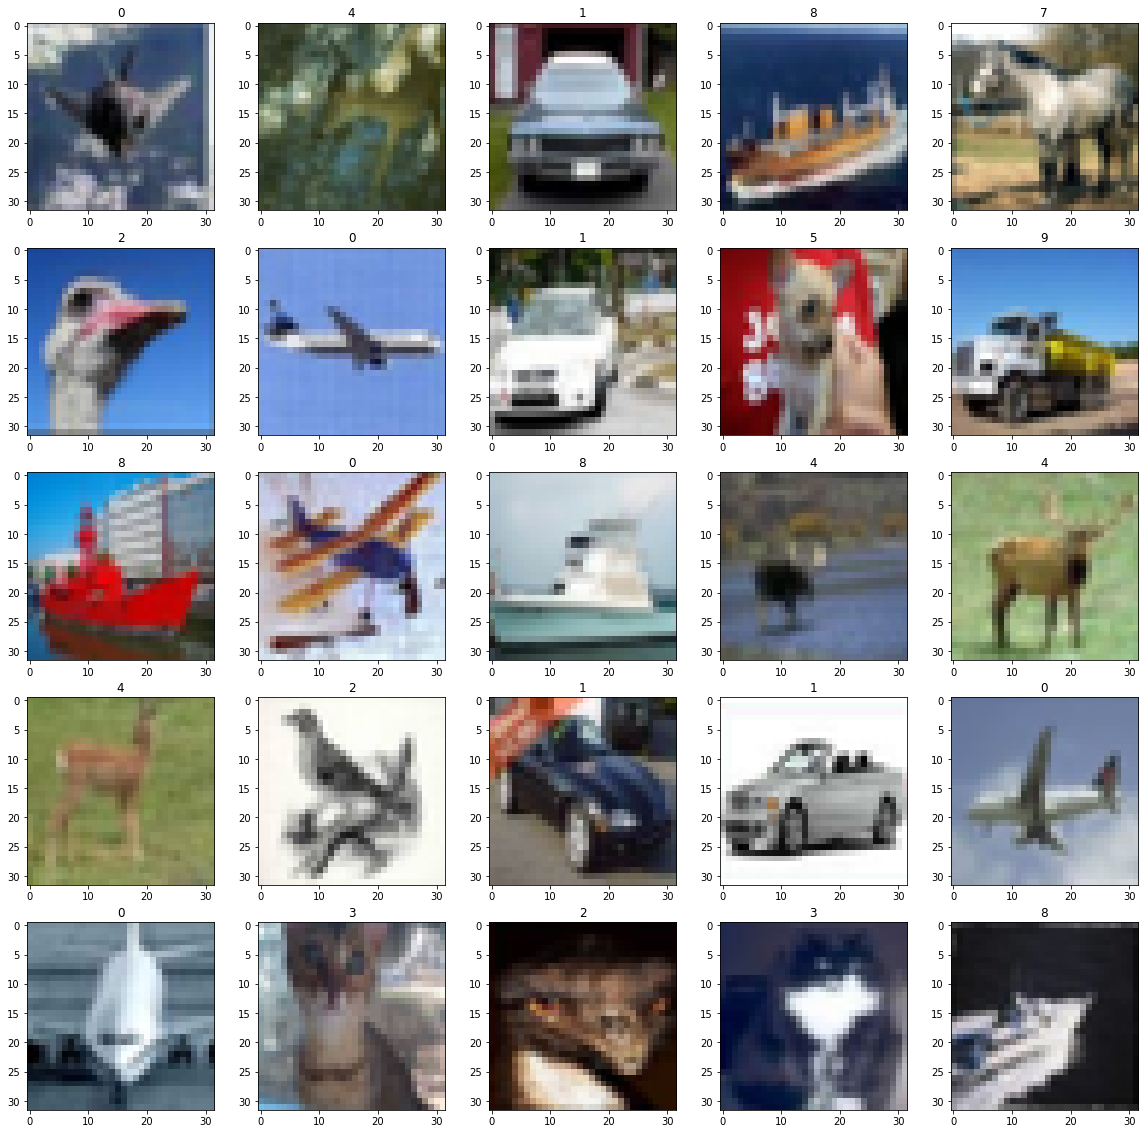

In [0]:
# #Images/n02105855-Shetland_sheepdog/n02105855_9415.jpg

# import glob
# import os

# import numpy as np
# from matplotlib.image import imread
# %matplotlib inline
# import matplotlib.pyplot as plt

# # get image parts
# def get_image_parts(image_path):
#     """Given a full path to an image, return its parts."""
#     parts = image_path.split(os.path.sep)
#     #print(parts)
#     filename = parts[2]
#     filename_no_ext = filename.split('.')[0]
#     classname = parts[1]
#     train_or_test = parts[0]
    
#     return train_or_test, classname, filename_no_ext, filename
    
    
# sample_images = list(glob.glob(os.path.join('train/', '*/*'), recursive=True))
# np.random.seed(42)
# rand_imgs = np.random.choice(sample_images, size=5*5)
# fig, axarr = plt.subplots(5, 5, figsize=(20, 20))

# for i, rand_img in enumerate(rand_imgs):
#     train_or_test, classname, filename_no_ext, filename = get_image_parts(rand_img)
    
#     j = i // 5
#     k = i % 5
#     axarr[j][k].imshow(imread(rand_img))
#     axarr[j][k].title.set_text(classname)
#     axarr[j][k].grid(False)

In [0]:
ls -l

In [0]:
# from PIL import Image
# import numpy

# def img_square(im_pth='', desired_size=224):
#     im = Image.open(im_pth)
#     old_size = im.size  # (width, height) format

#     ratio = float(desired_size)/max(old_size)
#     new_size = tuple([int(x*ratio) for x in old_size])

#     new_im = im.resize(new_size, Image.ANTIALIAS)

#     return new_im
    
# path = 'train/0/twinjet_s_001442.png'

# orig_arr = img_square(path, 399)   

# #convert to RGB and Save
# orig_arr = orig_arr.convert('RGB')
# orig_arr.save('test.jpg')

# from IPython.display import Image 
# Image(filename='test.jpg')

In [4]:
# from PIL import Image
# import numpy

# def convert_img_square(im_pth='', dest_path='', desired_size=224):
# #     print(im_pth)
    
#     im = Image.open(im_pth)
#     old_size = im.size  # (width, height) format

#     ratio = float(desired_size)/max(old_size)
#     new_size = tuple([int(x*ratio) for x in old_size])

# #     new_im = im.resize(new_size, Image.ANTIALIAS)
#     new_im = im.resize(new_size)
    
#     new_im = new_im.convert('RGB')
    
#     new_im.save(dest_path)

#     return True
    
# # path = 'train/0/twinjet_s_001442.png'
# # dest_path = 't1/test4.jpg'

# # orig_arr = convert_img_square(path, dest_path, 499)   

# # #convert to RGB and Save
# # # orig_arr = orig_arr.convert('RGB')
# # # orig_arr.save('t1/test2.jpg')

# # from IPython.display import Image 
# # Image(filename='t1/test4.jpg')

In [0]:
ls -l

In [0]:
%rm -r train_resized
%mkdir train_resized

In [5]:
# ####=======================
# import glob
# import os
# import shutil
# import random

# #move class folder from classname_# to classname/#

# def get_image_parts(image_path):
#     """Given a full path to an image, return its parts."""
#     parts = image_path.split(os.path.sep)
#     #print(parts)
#     filename = parts[2]
#     filename_no_ext = filename.split('.')[0]
#     classname = parts[1]
#     train_or_test = parts[0]
    
#     return train_or_test, classname, filename_no_ext, filename

# move_folders = ['train']
# dest_folder = 'train_resized_345'
# data_file = []

# # look for all images in sub-folders
# for folder in move_folders:
#     class_folders = glob.glob(os.path.join(folder, '*'))
#     print('folder %s' %class_folders)
    
# #     for sub_folder in class_folders:
# #         sub_class_folders = glob.glob(os.path.join(sub_folder, '*'))    
# #         print('sub folder %s' %sub_class_folders)
        
#     for iid_class in class_folders:
#         print(iid_class)
        
#         class_files = glob.glob(os.path.join(iid_class, '*.png'))
        
# #         #Determize Set# (No Suffle)
#         set = len(class_files)
#         inner = range(0*set, 1*set) #all

#         print('moving %d files' %(len(inner)))

# #         random_list = random.sample(range(len(class_files)), int(len(class_files)/5)) #1/5 dataset
# #         for idx in range(len(random_list)):

#         for idx in range(len(inner)):
#             src = class_files[inner[idx]]

#             train_or_test, classname, filename_no_ext, filename = get_image_parts(src)
#             dst = os.path.join(dest_folder, classname, filename)

#             # image directory
#             img_directory = os.path.join(dest_folder, classname)

#             # create folder if not existed
#             if not os.path.exists(img_directory):
#                 os.makedirs(img_directory)
                
#             # convert image
#             convert_img_square(src, dst, 345)
# #             #moving file
# #             shutil.move(src, dst)
# # #                 shutil.copy(src, dst)


folder ['train/5', 'train/4', 'train/9', 'train/1', 'train/0', 'train/2', 'train/6', 'train/7', 'train/8', 'train/3']
train/5
moving 5000 files
train/4
moving 5000 files
train/9
moving 5000 files
train/1
moving 5000 files
train/0
moving 5000 files
train/2
moving 5000 files
train/6
moving 5000 files
train/7
moving 5000 files
train/8
moving 5000 files
train/3
moving 5000 files


In [6]:
# ####=======================
# import glob
# import os
# import shutil
# import random

# #move class folder from classname_# to classname/#

# def get_image_parts(image_path):
#     """Given a full path to an image, return its parts."""
#     parts = image_path.split(os.path.sep)
#     #print(parts)
#     filename = parts[2]
#     filename_no_ext = filename.split('.')[0]
#     classname = parts[1]
#     train_or_test = parts[0]
    
#     return train_or_test, classname, filename_no_ext, filename

# move_folders = ['test']
# dest_folder = 'test_resized_345'
# data_file = []

# # look for all images in sub-folders
# for folder in move_folders:
#     class_folders = glob.glob(os.path.join(folder, '*'))
#     print('folder %s' %class_folders)
    
# #     for sub_folder in class_folders:
# #         sub_class_folders = glob.glob(os.path.join(sub_folder, '*'))    
# #         print('sub folder %s' %sub_class_folders)
        
#     for iid_class in class_folders:
#         print(iid_class)
        
#         class_files = glob.glob(os.path.join(iid_class, '*.png'))
        
# #         #Determize Set# (No Suffle)
#         set = len(class_files)
#         inner = range(0*set, 1*set) #all

#         print('moving %d files' %(len(inner)))

# #         random_list = random.sample(range(len(class_files)), int(len(class_files)/5)) #1/5 dataset
# #         for idx in range(len(random_list)):

#         for idx in range(len(inner)):
#             src = class_files[inner[idx]]

#             train_or_test, classname, filename_no_ext, filename = get_image_parts(src)
#             dst = os.path.join(dest_folder, classname, filename)

#             # image directory
#             img_directory = os.path.join(dest_folder, classname)

#             # create folder if not existed
#             if not os.path.exists(img_directory):
#                 os.makedirs(img_directory)
                
#             # convert image
#             convert_img_square(src, dst, 345)
# #             #moving file
# #             shutil.move(src, dst)
# # #                 shutil.copy(src, dst)


folder ['test/5', 'test/4', 'test/9', 'test/1', 'test/0', 'test/2', 'test/6', 'test/7', 'test/8', 'test/3']
test/5
moving 1000 files
test/4
moving 1000 files
test/9
moving 1000 files
test/1
moving 1000 files
test/0
moving 1000 files
test/2
moving 1000 files
test/6
moving 1000 files
test/7
moving 1000 files
test/8
moving 1000 files
test/3
moving 1000 files


In [0]:
path = 'train_resized/0/twinjet_s_001442.png'
# dest_path = 't1/test4.jpg'

# orig_arr = convert_img_square(path, dest_path, 499)   

# #convert to RGB and Save
# # orig_arr = orig_arr.convert('RGB')
# # orig_arr.save('t1/test2.jpg')

from IPython.display import Image 
Image(filename=path)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import sleep

%matplotlib inline

image = mpimg.imread(path)
plt.imshow(image)
plt.show()

In [0]:
ls -l

In [0]:
!zip -r train_resized_299.zip train_resized
!zip -r test_resized_299.zip test_resized

In [0]:
%cp train_resized_299.zip gdrive/My\ Drive/cifar_train_resized_299.zip
%cp test_resized_299.zip gdrive/My\ Drive/cifar_test_resized_299.zip 

In [0]:
cd gdrive/My\ Drive

In [0]:
ls -l

In [7]:
# !pip install keras_efficientnets

In [0]:
ls -l

total 413780
-rw-------  1 root root  24485111 Oct 16 22:25 cifar_test.zip
-rw-------  1 root root 122511088 Oct 16 22:25 cifar_train.zip
drwx------  3 root root      4096 Oct 17 00:10 gdrive/
drwxr-xr-x  1 root root      4096 Aug 27 16:17 sample_data/
drwxr-xr-x  2 root root      4096 Oct 16 23:28 t1/
drwxr-xr-x 12 root root      4096 Oct 16 15:36 test/
drwxr-xr-x 12 root root      4096 Oct 16 23:44 test_resized/
-rw-r--r--  1 root root  46093692 Oct 17 00:01 test_resized_299.zip
drwxr-xr-x 12 root root      4096 Oct 16 15:33 train/
drwxr-xr-x 12 root root      4096 Oct 16 23:41 train_resized/
-rw-r--r--  1 root root 230580828 Oct 17 00:01 train_resized_299.zip


In [0]:
mkdir checkpoints

In [8]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 32

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'st'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints','Cifar100_Eff_B4_299_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cifar100_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cifar100_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)
else:
    model_mul = model_1
    
epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.
Epoch 1/40
1563/1563 [==============================] - 1112s 711ms/step - loss: 2.3863 - acc: 0.4001 - val_loss: 0.9165 - val_acc: 0.7400

Epoch 00001: val_acc improved from -inf to 0.74000, saving model to checkpoints/Cifar100_Eff_B4_299_STD.hdf5
Epoch 2/40
1563/1563 [==============================] - 1029s 658ms/step - loss: 1.4199 - acc: 0.6019 - val_loss: 0.6943 - val_acc: 0.7894

Epoch 00002: val_acc improved from 0.74000 to 0.78940, saving model to checkpoints/Cifar100_Eff_B4_299_STD.hdf5
Epoch 3/40
1563/1563 [==============================] - 1035s 662ms/step - loss: 1.1967 - acc: 0.6604 - val_loss: 0.6397 - val_acc: 0.8142

Epoch 00003: val_acc improved from 0.78940 to 0.81420, saving model to checkpoints/Cifar100_Eff_B4_299_STD.hdf5
Epoch 4/40
1563/1563 [==============================] - 1038s 664ms/step - loss: 1.0557 - acc: 0.6955 - val_loss: 0.6278 - val_acc: 0.8188

Epoch 00004: val_


Epoch 00039: val_acc did not improve from 0.85650
Epoch 40/40
1563/1563 [==============================] - 1002s 641ms/step - loss: 0.2018 - acc: 0.9352 - val_loss: 0.8351 - val_acc: 0.8462

Epoch 00040: val_acc did not improve from 0.85650


In [9]:
model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B4_299_STD.hdf5'))

In [10]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'Cifar100_Eff_B4_299_STD_L2.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Epoch 1/15
1563/1563 [==============================] - 1083s 693ms/step - loss: 0.2707 - acc: 0.9150 - val_loss: 0.6414 - val_acc: 0.8628

Epoch 00001: val_acc improved from -inf to 0.86280, saving model to checkpoints/Cifar100_Eff_B4_299_STD_L2.hdf5
Epoch 2/15
1563/1563 [==============================] - 1003s 641ms/step - loss: 0.2447 - acc: 0.9220 - val_loss: 0.6389 - val_acc: 0.8628

Epoch 00002: val_acc did not improve from 0.86280
Epoch 3/15
1563/1563 [==============================] - 1004s 643ms/step - loss: 0.2335 - acc: 0.9265 - val_loss: 0.6421 - val_acc: 0.8641

Epoch 00003: val_acc improved from 0.86280 to 0.86410, saving model to checkpoints/Cifar100_Eff_B4_299_STD_L2.hdf5
Epoch 4/15
 492/1563 [========>.....................] - ETA: 10:47 - loss: 0.2236 - acc: 0.9315

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 1006s 644ms/step - loss: 0.2014 - acc: 0.9368 - val_loss: 0.6421 - val_acc: 0.8652

Epoch 00008: val_acc improved from 0.86410 to 0.86520, saving model to checkpoints/Cifar100_Eff_B4_299_STD_L2.hdf5
Epoch 9/15
1563/1563 [==============================] - 1001s 640ms/step - loss: 0.1980 - acc: 0.9367 - val_loss: 0.6413 - val_acc: 0.8633

Epoch 00009: val_acc did not improve from 0.86520
Epoch 10/15
1052/1563 [===================>..........] - ETA: 5:09 - loss: 0.1938 - acc: 0.9373

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 1002s 641ms/step - loss: 0.1947 - acc: 0.9371 - val_loss: 0.6415 - val_acc: 0.8628

Epoch 00010: val_acc did not improve from 0.86520
Epoch 11/15
1563/1563 [==============================] - 1003s 642ms/step - loss: 0.1901 - acc: 0.9394 - val_loss: 0.6415 - val_acc: 0.8630

Epoch 00011: val_acc did not improve from 0.86520
Epoch 12/15
1563/1563 [==============================] - 1001s 641ms/step - loss: 0.1839 - acc: 0.9416 - val_loss: 0.6521 - val_acc: 0.8613

Epoch 00012: val_acc did not improve from 0.86520
Epoch 13/15
1563/1563 [==============================] - 1001s 640ms/step - loss: 0.1837 - acc: 0.9418 - val_loss: 0.6503 - val_acc: 0.8627

Epoch 00013: val_acc did not improve from 0.86520
Epoch 14/15
1563/1563 [==============================] - 1003s 642ms/step - loss: 0.1721 - acc: 0.9454 - val_loss: 0.6529 - val_acc: 0.8601

Epoch 00014: val_acc did not improve from 0.86520
Epoch 15/15
1563/1563 [==============================] - 

In [11]:
# #Using multiple models if more than 1 GPU
# NUM_GPU = 4
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B4_299_STD_L2.hdf5'))

In [18]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time, os
from math import ceil

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 36

train_set = train_datagen.flow_from_directory('train_resized_345',
                                                 target_size = (345, 345),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test_resized_345',
                                                 target_size = (345, 345),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cifar10_Eff_B5_345_1511_v1.csv')
results.head()

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
278/278 [==============================] - 93s 335ms/step


,file_name,predicted1
0,0/aeroplane_s_000002.png,0
1,0/aeroplane_s_000040.png,0
2,0/aeroplane_s_000045.png,0
3,0/aeroplane_s_000063.png,0
4,0/airbus_s_000009.png,0


In [19]:
cp Cifar10_Eff_B5_345_1511_v1.csv /home/bribeiro/Phong/Nat19/Cifar10_Eff_B5_345_1511_v1.csv

In [20]:
np.save(os.path.join('pred_npy','Cifar10_Eff_B5_345_L2.npy'), predict1)

In [29]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 72

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

test_datagen_crop = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

testing_set_crop = test_datagen_crop.flow_from_directory('test_resized_345',
                                                 target_size = (370, 370),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 345)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

tta_steps = 4
# predictions = []

# import tensorflow as tf
# with tf.device('/gpu:0'):
for i in range(tta_steps):
    print(i)
    testing_set_crop.reset()
    if NUM_GPU != 1:
        preds=model_mul.predict_generator(test_crops, 
                                           steps = step_size_test_crop,
#                                            max_queue_size=16,
#                                                use_multiprocessing=True,
#                                            workers=1,
                                           verbose=1)    
#     else:
#         preds=model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)  
#     preds=model_2.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cifar10_Eff_B5_345_STD_tta_7.csv')
results.head(10)

Found 10000 images belonging to 10 classes.
0
139/139 [==============================] - 72s 521ms/step
1
139/139 [==============================] - 72s 515ms/step
2
139/139 [==============================] - 71s 513ms/step
3
139/139 [==============================] - 73s 527ms/step


,id,predicted
0,0/aeroplane_s_000002.png,0
1,0/aeroplane_s_000040.png,0
2,0/aeroplane_s_000045.png,0
3,0/aeroplane_s_000063.png,0
4,0/airbus_s_000009.png,0
5,0/airbus_s_000030.png,0
6,0/airbus_s_000049.png,0
7,0/airbus_s_000099.png,0
8,0/airbus_s_000108.png,0
9,0/airbus_s_000131.png,0


In [30]:
cp Cifar10_Eff_B5_345_STD_tta_7.csv /home/bribeiro/Phong/Nat19/Cifar10_Eff_B5_345_STD_tta_7.csv

In [28]:
np.save(os.path.join('pred_npy','Cifar10_Eff_B5_345_L2_TTA3.npy'), mean_pred)

In [12]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'Cifar100_Eff_B4_299_STD_L3.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Epoch 1/15
1563/1563 [==============================] - 1096s 701ms/step - loss: 0.1948 - acc: 0.9389 - val_loss: 0.6395 - val_acc: 0.8642

Epoch 00001: val_acc improved from -inf to 0.86420, saving model to checkpoints/Cifar100_Eff_B4_299_STD_L3.hdf5
Epoch 2/15
1563/1563 [==============================] - 1004s 643ms/step - loss: 0.1894 - acc: 0.9398 - val_loss: 0.6359 - val_acc: 0.8654

Epoch 00002: val_acc improved from 0.86420 to 0.86540, saving model to checkpoints/Cifar100_Eff_B4_299_STD_L3.hdf5
Epoch 3/15
1563/1563 [==============================] - 1004s 642ms/step - loss: 0.1888 - acc: 0.9408 - val_loss: 0.6405 - val_acc: 0.8642

Epoch 00003: val_acc did not improve from 0.86540
Epoch 4/15
1563/1563 [==============================] - 1002s 641ms/step - loss: 0.1881 - acc: 0.9407 - val_loss: 0.6403 - val_acc: 0.8635

Epoch 00004: val_acc did not improve from 0.86540
Epoch 5/15
1563/1563 [==============================] - 1002s 641ms/step - loss: 0.1844 - acc: 0.9414 - val_loss:

In [13]:
# #Using multiple models if more than 1 GPU
# NUM_GPU = 4
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B4_299_STD_L3.hdf5'))

In [14]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time, os
from math import ceil

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 36

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cifar100_Eff_B4_299_STD_L3_2408_v1.csv')
results.head()

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.
278/278 [==============================] - 71s 254ms/step


,file_name,predicted1
0,apple/0001.png,apple
1,apple/0002.png,apple
2,apple/0003.png,apple
3,apple/0004.png,apple
4,apple/0005.png,apple


In [15]:
np.save(os.path.join('pred_npy','Cifar100_Eff_B4_299_STD_L3.npy'), predict1)

In [16]:
mean_pred3_1 = np.load(os.path.join('pred_npy','Cifar100_SEResNext101_LRG299_Mul.npy'))
mean_pred3_2 = np.load(os.path.join('pred_npy','Cifar100_Eff_B7_299_STD_L3_v2.npy'))
mean_pred3_3 = np.load(os.path.join('pred_npy','Cifar100_EfficientB0_299_STD_L3_v2.npy'))
mean_pred3_4 = np.load(os.path.join('pred_npy','Cifar100_Xception_LRG299_Mul.npy'))
mean_pred3_5 = np.load(os.path.join('pred_npy','Cifar100_Eff_B4_299_STD_L3.npy'))

mean_pred3 = (mean_pred3_1+mean_pred3_2+mean_pred3_3+mean_pred3_4+mean_pred3_5)/5
print(mean_pred3[0:9])

[[8.97696853e-01 8.18545800e-07 3.21348625e-06 3.43951911e-07
  1.80373434e-07 1.93226469e-06 9.80362991e-09 5.03197498e-06
  4.91182846e-08 5.71218470e-06 1.70425046e-04 5.03607316e-06
  9.05443116e-08 2.51659230e-06 9.24848109e-09 1.05343496e-07
  1.55357645e-06 1.66290803e-07 8.44123861e-07 1.96870616e-07
  7.54711067e-08 2.79177311e-06 6.61920069e-07 1.83156406e-08
  8.40456771e-09 2.64687685e-07 2.38807218e-07 2.31274697e-08
  1.21635296e-07 1.72344102e-07 2.60158617e-06 2.08074425e-07
  2.96101433e-07 2.77430189e-07 9.31647577e-08 2.01282128e-05
  5.76571040e-07 2.18845162e-06 7.07180874e-08 1.87359319e-07
  7.81133167e-06 1.08542895e-06 7.18491489e-09 7.99983990e-09
  5.28185581e-07 6.81874752e-08 1.55442717e-06 2.48736498e-09
  6.00849788e-08 3.81061014e-08 1.28019195e-07 8.95351968e-06
  6.47143561e-10 6.87309727e-03 1.92585041e-08 1.94008408e-06
  1.26077548e-08 9.13682431e-02 3.88951605e-07 1.11817130e-07
  2.96447098e-07 3.31347479e-07 2.70241060e-07 6.75155292e-08
  2.5296

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 20

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

train_datagen = ImageDataGenerator(

)

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )
        
test_datagen_crop = ImageDataGenerator(
)

testing_set_crop = test_datagen_crop.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 299)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

predicted_class_indices_mean=np.argmax(mean_pred3,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cifar100_MulModels299_AVG_Assembe_2408_v1.csv')
results.head(20)

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.


,id,predicted
0,apple/0001.png,apple
1,apple/0002.png,apple
2,apple/0003.png,apple
3,apple/0004.png,pear
4,apple/0005.png,apple
5,apple/0006.png,apple
6,apple/0007.png,apple
7,apple/0008.png,apple
8,apple/0009.png,apple
9,apple/0010.png,apple


In [18]:
cp Cifar100_MulModels299_AVG_Assembe_2408_v1.csv /home/bribeiro/Phong/Nat19/Cifar100_MulModels299_AVG_Assembe_2408_v1.csv

In [21]:
a1 = mean_pred3_1
a2 = mean_pred3_2
a3 = mean_pred3_3
a4 = mean_pred3_4
a5 = mean_pred3_5


In [22]:
for i in range(len(a1)):
    i_max = np.argmax(a1[i], axis=0)
    for idx in range(10):
        if idx != i_max:
            a1[i][idx] = 0
        else:
            a1[i][idx] = 1            
# print(a1) 

In [23]:
for i in range(len(a2)):
    i_max = np.argmax(a2[i], axis=0)
    for idx in range(10):
        if idx != i_max:
            a2[i][idx] = 0
        else:
            a2[i][idx] = 1             
# print(a2)  

In [24]:
for i in range(len(a3)):
    i_max = np.argmax(a3[i], axis=0)
    for idx in range(10):
        if idx != i_max:
            a3[i][idx] = 0
        else:
            a3[i][idx] = 1             
# print(a3)  

In [25]:
for i in range(len(a4)):
    i_max = np.argmax(a4[i], axis=0)
    for idx in range(10):
        if idx != i_max:
            a4[i][idx] = 0
        else:
            a4[i][idx] = 1             
# print(a4)  

In [26]:
for i in range(len(a5)):
    i_max = np.argmax(a5[i], axis=0)
    for idx in range(10):
        if idx != i_max:
            a5[i][idx] = 0
        else:
            a5[i][idx] = 1             
# print(a3)  

In [27]:
mean_a = (a1+a2+a3+a4+a5)/5

In [28]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np
from keras_applications.imagenet_utils import preprocess_input

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 40

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

predicted_class_indices_mean=np.argmax(mean_a,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=test_set1.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cifar100_MulModels299_AVG_Assembe_2408_v2.csv')
results.head(20)

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.


,id,predicted
0,apple/0001.png,apple
1,apple/0002.png,apple
2,apple/0003.png,apple
3,apple/0004.png,pear
4,apple/0005.png,apple
5,apple/0006.png,apple
6,apple/0007.png,apple
7,apple/0008.png,apple
8,apple/0009.png,apple
9,apple/0010.png,apple


In [29]:
cp Cifar100_MulModels299_AVG_Assembe_2408_v2.csv /home/bribeiro/Phong/Nat19/Cifar100_MulModels299_AVG_Assembe_2408_v2.csv